# Определение стоимости автомобилей

Текущее исследование производится в интересах сервиса по продаже автомобиля, где идет разработка приложения с функцией определения рыночной стоимости автомобиля.

**Цель исследования:** построить модель, которая с достаточной точностью предсказывала бы для клиентов стоимость автомобиля по предложенным параметрам

Предоставлена выгрузка объявлений из сервиса по продвжи автомобиля, где содержатся данные о технических характеристиках, комплектации и ценах других автомобилей.

**Ограничения исследования:**
1. Заказчику важны:
    - качество предсказания
    - скорость предсказания
    - время обучения
2. Следует использовать несколько различных моделей одна из которых — LightGBM, как минимум одна — не бустинг
3. Значение метрики RMSE должно быть меньше 2500

**Ход исследования:**  
Наше исследование будет проходить в шесть этапов:  
1. Загрузка, обзор и предобработка данных
2. Подготовка выборок под различные модели
3. Обучение моделей и подбор гиперпараметров
4. Выбор модели исходя из значения RMSE и скорости обучения и предсказания
5. Тестирование выбранной модели и проверка ее на адексатность
6. Подготовка общего вывода


**Описание данных**  
* **Признаки**  
    - **DateCrawled** — дата скачивания анкеты из базы  
    - **VehicleType** — тип автомобильного кузова  
    - **RegistrationYear** — год регистрации автомобиля  
    - **Gearbox** — тип коробки передач  
    - **Power** — мощность (л.с.)  
    - **Model** — модель автомобиля  
    - **Kilometer** — пробег (км)  
    - **RegistrationMonth** — месяц регистрации автомобиля  
    - **FuelType** — тип топлива  
    - **Brand** — марка автомобиля  
    - **Repaired** — была машина в ремонте или нет  
    - **DateCreated** — дата создания анкеты  
    - **NumberOfPictures** — количество фотографий автомобиля  
    - **PostalCode** — почтовый индекс владельца анкеты (пользователя)  
    - **LastSeen** — дата последней активности пользователя  
* **Целевой признак**  
    - **Price** — цена (евро)  

Для начала импортируем библиотеки и зафиксируем глобальные константы:

In [1]:
# pip install catboost

In [2]:
# pip install lightgbm

In [3]:
# ! pip install -Uq scikit-learn
# ! pip install phik -q

In [4]:
import pandas as pd
import numpy as np
import warnings  
import time 
import re  # регулярки
import phik

import seaborn as sns  
import matplotlib.pyplot as plt  

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer  

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.preprocessing import OneHotEncoder 

from sklearn.tree import DecisionTreeRegressor  
from sklearn.linear_model import LinearRegression 
from catboost import CatBoostRegressor 
from lightgbm import LGBMRegressor

from sklearn.model_selection import RandomizedSearchCV
from sklearn.dummy import DummyRegressor

In [5]:
# Общие константы:
MODE = '' 
MODE = 'check' 
# Константа-рычаг для проверки работы. Включает оптимальные гиперпараметры для моделей и выключает логирование. 
# Если закомментить, то будет включен перерасчет. 
# MODE = 'check' -- включено.
# Всё остальное -- выключено.

RAND_FIX = 12345 # Зафиксируем random_state

In [6]:
warnings.filterwarnings('ignore') # отключаем предупреждения

## Шаг 1 Подготовка данных

### 1.1 Открыть и изучить данные

In [7]:
try:
    d_auto = pd.read_csv('datasets/autos.csv', sep=',') # загружаем с локального хранилища
    
    print('*' * 50, 'Данные о катрочтках продажи автомобилей', sep='\n')
    display(d_auto.head(5))
    print()
    d_auto.info()

except:
    d_auto = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv', sep=',') # загружаем из хранилища Яндекс
    
    print('Файл загружен из хранилища Яндекс')
    print('*' * 50, 'Данные о катрочтках продажи автомобилей', sep='\n')
    display(d_auto.head(5))
    print()
    d_auto.info()

**************************************************
Данные о катрочтках продажи автомобилей


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object

Обзорно взглянем на распределения:

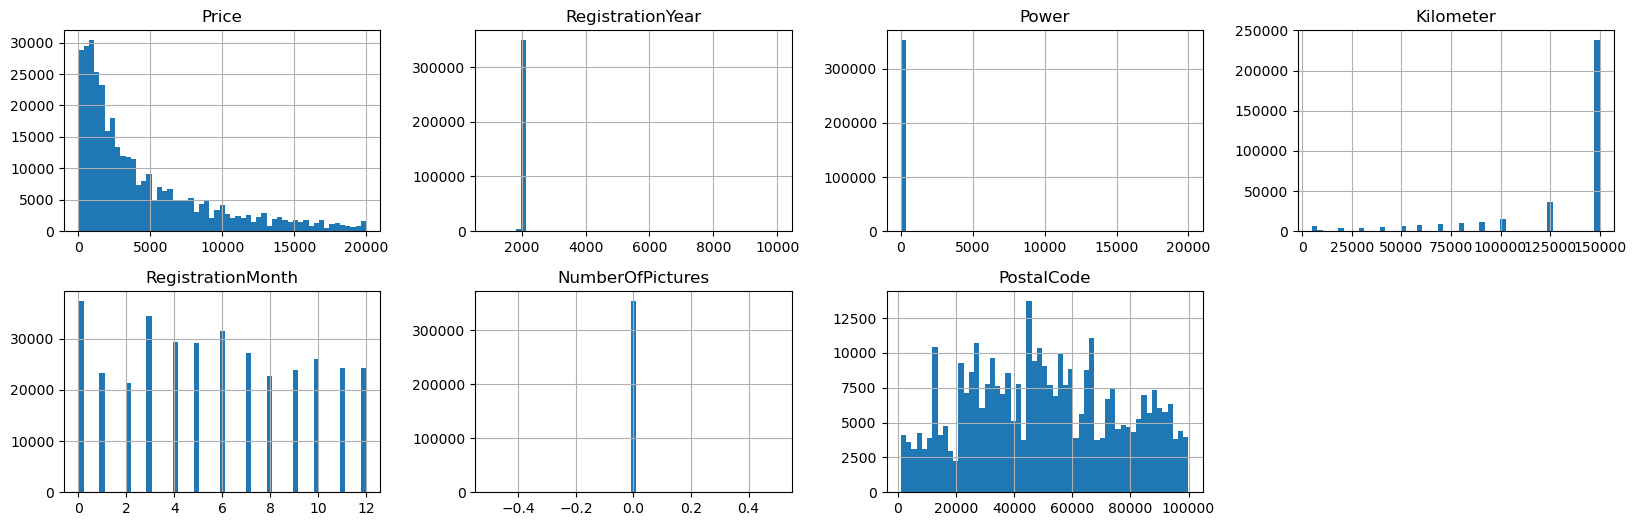

In [8]:
ax = d_auto.hist(bins=55, figsize=(20, 6), layout=(2, 4))

Посмотрим на коэффициенты корреляции:

In [9]:
d_auto[['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'NumberOfPictures', 'PostalCode']].\
phik_matrix()

interval columns not set, guessing: ['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'NumberOfPictures', 'PostalCode']


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,PostalCode
Price,1.000000,0.016816,0.005752,0.307892,0.185828,0.096123
RegistrationYear,0.016816,1.000000,0.088713,0.107644,0.036900,0.003015
Power,0.005752,0.088713,1.000000,0.008440,0.000000,0.000000
Kilometer,0.307892,0.107644,0.008440,1.000000,0.103169,0.042001
RegistrationMonth,0.185828,0.036900,0.000000,0.103169,1.000000,0.050215
PostalCode,0.096123,0.003015,0.000000,0.042001,0.050215,1.000000


Проверим, есть ли полные дубликаты:

In [10]:
d_auto.loc[d_auto.duplicated() == 1, :]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


Проверим категориалные признаки на неявные дубликаты и отобразим долю пропусков:

In [11]:
for col in ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'RegistrationMonth', 'Brand', 'Repaired']:
    print('*'*100)
    print('Уникальные значения по колонке', col, '==', d_auto[col].sort_values().unique())
    print()
    print('Процент пропусков по колонке', col, '==', round(d_auto[col].isna().sum()/d_auto.shape[0] * 100, 2), '%')
    print('\n')

****************************************************************************************************
Уникальные значения по колонке VehicleType == ['bus' 'convertible' 'coupe' 'other' 'sedan' 'small' 'suv' 'wagon' nan]

Процент пропусков по колонке VehicleType == 10.58 %


****************************************************************************************************
Уникальные значения по колонке Gearbox == ['auto' 'manual' nan]

Процент пропусков по колонке Gearbox == 5.6 %


****************************************************************************************************
Уникальные значения по колонке Model == ['100' '145' '147' '156' '159' '1_reihe' '1er' '200' '2_reihe' '300c'
 '3_reihe' '3er' '4_reihe' '500' '5_reihe' '5er' '601' '6_reihe' '6er'
 '7er' '80' '850' '90' '900' '9000' '911' 'a1' 'a2' 'a3' 'a4' 'a5' 'a6'
 'a8' 'a_klasse' 'accord' 'agila' 'alhambra' 'almera' 'altea' 'amarok'
 'antara' 'arosa' 'astra' 'auris' 'avensis' 'aveo' 'aygo' 'b_klasse'
 'b_max' 'beetle' 

Посмотрим на распределение значений количественных признаков:

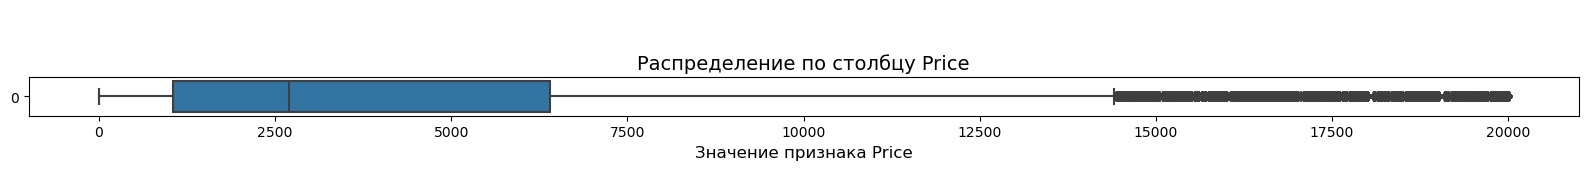

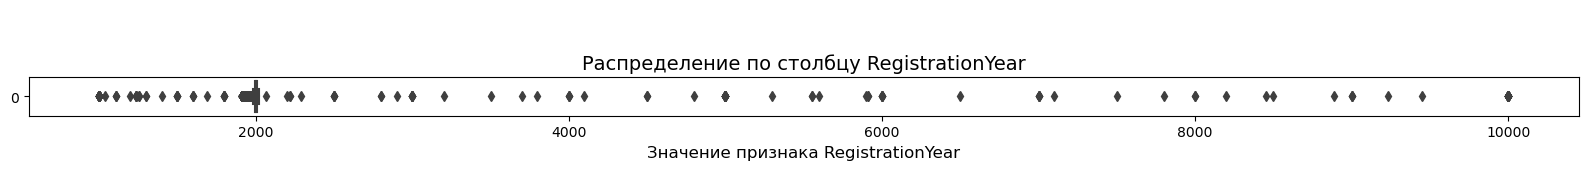

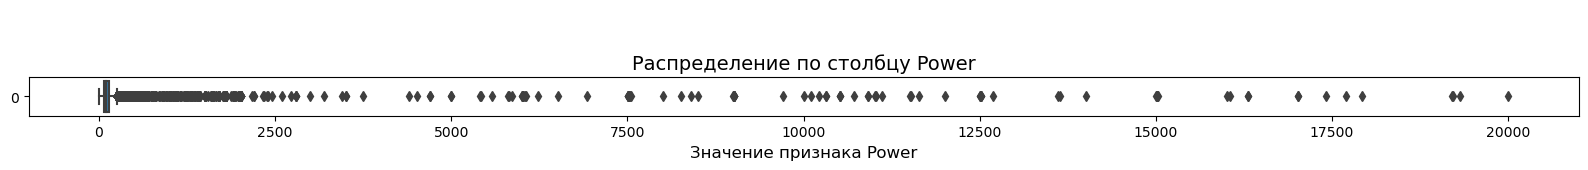

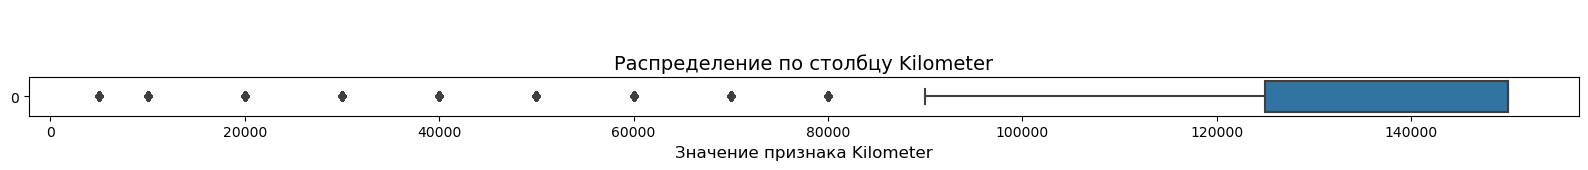

In [12]:
for col in ['Price', 'RegistrationYear', 'Power', 'Kilometer']:
    fig, ax = plt.subplots(figsize=(20, 0.5))
    sns.boxplot(data=d_auto.loc[:, col], orient='h')
    label = 'Значение признака ' + col
    ax.set_xlabel(label, fontsize=12)
    title = '\n\nРаспределение по столбцу ' + col
    ax.set_title(title, fontsize=14)

### 1.2 Предобработка

#### 1.2.1 Наименования колонок

Переводим наименования в snake_case формат:

In [13]:
col_new=[]
for col in d_auto.columns:
    col_new.append(re.sub(r'(?<!^)(?=[A-Z])', '_', col).lower())

d_auto.columns = col_new
d_auto.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

#### 1.2.2 Удаление полных дубликатов

In [14]:
d_auto = d_auto.drop_duplicates()
d_auto.shape

(354365, 16)

#### 1.2.3 Обработка неявных дублей

##### 1.2.3.1 Обработка fuel_type

В столбце "fuel_type" встречаются значения-синонимы: gasoline и petrol, объединим их:

In [15]:
d_auto.groupby('fuel_type')['fuel_type'].count().sort_values()

fuel_type
electric        90
other          204
hybrid         233
cng            565
lpg           5310
gasoline     98719
petrol      216349
Name: fuel_type, dtype: int64

In [16]:
d_auto.loc[d_auto['fuel_type'] == 'gasoline', 'fuel_type'] = 'petrol'

In [17]:
d_auto.groupby('fuel_type')['fuel_type'].count().sort_values()

fuel_type
electric        90
other          204
hybrid         233
cng            565
lpg           5310
petrol      315068
Name: fuel_type, dtype: int64

##### 1.2.3.2 Обработка brand

В столбце "brand" встречается значение "sonstige_autos", которое, очевидно, не является брендом. Однако, sonstige_autos -- другие автомобили на немецком языке, причем, если пристально посмотреть на значения "postal_code", то можно заметить, что они относятся к адресам преимущественно на территории Германии. Так что, заменим "sonstige_autos" на "other", как в столбцах "vehicle_type", "fuel_type" и "model".

In [18]:
d_auto.loc[(d_auto['brand'] == 'sonstige_autos') | ((d_auto['brand'] == 'other'))].groupby('brand')['brand'].count()

brand
sonstige_autos    3374
Name: brand, dtype: int64

In [19]:
d_auto.loc[d_auto['brand'] == 'sonstige_autos', 'brand'] = 'other'
d_auto.loc[(d_auto['brand'] == 'sonstige_autos') | ((d_auto['brand'] == 'other'))].groupby('brand')['brand'].count()

brand
other    3374
Name: brand, dtype: int64

In [20]:
pd.set_option('display.max_rows', None)
display(d_auto[['brand','model']].pivot_table(index=['brand','model']))
pd.reset_option('display.max_rows')

Empty DataFrame
Columns: []
Index: [(alfa_romeo, 145), (alfa_romeo, 147), (alfa_romeo, 156), (alfa_romeo, 159), (alfa_romeo, other), (alfa_romeo, spider), (audi, 100), (audi, 200), (audi, 80), (audi, 90), (audi, a1), (audi, a2), (audi, a3), (audi, a4), (audi, a5), (audi, a6), (audi, a8), (audi, other), (audi, q3), (audi, q5), (audi, q7), (audi, tt), (bmw, 1er), (bmw, 3er), (bmw, 5er), (bmw, 6er), (bmw, 7er), (bmw, i3), (bmw, m_reihe), (bmw, other), (bmw, x_reihe), (bmw, z_reihe), (chevrolet, aveo), (chevrolet, captiva), (chevrolet, matiz), (chevrolet, other), (chevrolet, spark), (chrysler, 300c), (chrysler, crossfire), (chrysler, grand), (chrysler, other), (chrysler, ptcruiser), (chrysler, voyager), (citroen, berlingo), (citroen, c1), (citroen, c2), (citroen, c3), (citroen, c4), (citroen, c5), (citroen, other), (dacia, duster), (dacia, lodgy), (dacia, logan), (dacia, other), (dacia, sandero), (daewoo, kalos), (daewoo, lanos), (daewoo, matiz), (daewoo, nubira), (daewoo, other), (daihatsu, charade), (daihatsu, cuore), (daihatsu, materia), (daihatsu, move), (daihatsu, other), (daihatsu, sirion), (daihatsu, terios), (fiat, 500), (fiat, bravo), (fiat, croma), (fiat, doblo), (fiat, ducato), (fiat, other), (fiat, panda), (fiat, punto), (fiat, seicento), (fiat, stilo), (ford, b_max), (ford, c_max), (ford, escort), (ford, fiesta), (ford, focus), (ford, fusion), (ford, galaxy), (ford, ka), (ford, kuga), (ford, mondeo), (ford, mustang), (ford, other), (ford, s_max), (ford, transit), (honda, accord), (honda, civic), (honda, cr_reihe), (honda, jazz), (honda, other), (hyundai, getz), (hyundai, i_reihe), (hyundai, other), (hyundai, santa), ...]

#### 1.2.4 Формирование даты регистрации автомобиля

1. Удалим значения 'registration_month', которые равны нулю
2. Сольем 'registration_year' и 'registration_month', так как 'registration_month' как отдельная единица менее осмыслена в сравнении с объединенным значением, а если объединить, то получим вменяемую характеристику, которая в двенадцать раз уточняет возраст автомобиля по сравнению с годом
3. Ограничим дату регистрации:
    - Сверху --  датой публикации объявления
    - Снизу -- датой выпуска первого серийного автомобиля
4. Переименовываем 'registration_year' в 'registration_year_month'
5. Сносим 'registration_month'

In [21]:
d_auto = d_auto.loc[d_auto['registration_month'] > 0, :]

d_auto['registration_year'] = d_auto['registration_year'] * 100 + d_auto['registration_month']
d_auto['date_created'] = (d_auto['date_created'].str[:4] + d_auto['date_created'].astype('str').str[5:7]).astype('int')

d_auto = d_auto.loc[(d_auto['registration_year'] <= d_auto['date_created']) & \
                    (d_auto['registration_year'] >= 1885), :]

d_auto = d_auto.rename(columns={'registration_year':'registration_year_month'})
d_auto = d_auto.drop('registration_month', axis = 1)

display(d_auto.head(2))
d_auto.info()

,date_crawled,price,vehicle_type,registration_year_month,gearbox,power,model,kilometer,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
1,2016-03-24 10:58:45,18300,coupe,201105,manual,190,NaN,125000,petrol,audi,yes,201603,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,200408,auto,163,grand,125000,petrol,jeep,NaN,201603,0,90480,2016-04-05 12:47:46


<class 'pandas.core.frame.DataFrame'>
Index: 300940 entries, 1 to 354368
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   date_crawled             300940 non-null  object
 1   price                    300940 non-null  int64 
 2   vehicle_type             294394 non-null  object
 3   registration_year_month  300940 non-null  int64 
 4   gearbox                  292260 non-null  object
 5   power                    300940 non-null  int64 
 6   model                    289795 non-null  object
 7   kilometer                300940 non-null  int64 
 8   fuel_type                287967 non-null  object
 9   brand                    300940 non-null  object
 10  repaired                 258161 non-null  object
 11  date_created             300940 non-null  int32 
 12  number_of_pictures       300940 non-null  int64 
 13  postal_code              300940 non-null  int64 
 14  last_seen                

#### 1.2.5 Обработка пропусков

Заполним пропуски в категориальных переменных 'vehicle_type', 'gearbox', 'model', 'fuel_type', 'repaired'.
К сожалению, в рамках каждой марки одного года может быть разные типы кузова, трансмиссии и топлива, поэтому мы не сможем ни удалить эти столбцы, ни заполнить их.  
Поэтому пропуски заполняем значением 'other', которое и так используется в исходном датасете.

In [22]:
d_auto[['vehicle_type', 'gearbox', 'model', 'fuel_type', 'repaired']] = \
d_auto[['vehicle_type', 'gearbox', 'model', 'fuel_type', 'repaired']].fillna('other')

Ну и удалим совсем уж "мусорные" записи, где other во всех предзаполненных значениях

In [23]:
d_auto = d_auto.loc[~((d_auto['vehicle_type'] == 'other') & (d_auto['gearbox'] == 'other') & \
           (d_auto['model'] == 'other') & (d_auto['fuel_type'] == 'other') & (d_auto['repaired'] == 'other')), :]
d_auto.shape

(300627, 15)

#### 1.2.6 Обработка выбросов

Выбросы замечены в переменных 'registration_year' (уже обработано), 'power' и 'price'.  
В серийных автомобилях мощность двигателя не превышает 2 000 лошадиных сил, удалим значения больше.
Ну и удалим нулевые значения.

In [24]:
d_auto = d_auto.loc[(d_auto['power'] <= 2000) & (d_auto['power'] > 0), :]
d_auto.shape

(279406, 15)

Точно также поступим с автомобилями, которые дешевле 100 евро:

In [25]:
d_auto = d_auto.loc[d_auto['price'] >= 100, :]
d_auto.shape

(274163, 15)

#### 1.2.7 Удаление признаков

Как и планировали в П1.1, удаляем признаки, которые относятся к объявлению, а не автомобилю.

Они нам понадобились на предобработке, на обучении будут мешать. Более того, столбец "number_of_pictures", например, явно поломан -- там только нули.

In [26]:
d_auto = \
d_auto.drop(['date_crawled', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen'], axis = 1).reset_index(drop=True)

display(d_auto.head(5))
print()
display(d_auto.shape)
d_auto.info()

,price,vehicle_type,registration_year_month,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,18300,coupe,201105,manual,190,other,125000,petrol,audi,yes
1,9800,suv,200408,auto,163,grand,125000,petrol,jeep,other
2,1500,small,200106,manual,75,golf,150000,petrol,volkswagen,no
3,3600,small,200807,manual,69,fabia,90000,petrol,skoda,no
4,650,sedan,199510,manual,102,3er,150000,petrol,bmw,yes


(274163, 10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 274163 entries, 0 to 274162
Data columns (total 10 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   price                    274163 non-null  int64 
 1   vehicle_type             274163 non-null  object
 2   registration_year_month  274163 non-null  int64 
 3   gearbox                  274163 non-null  object
 4   power                    274163 non-null  int64 
 5   model                    274163 non-null  object
 6   kilometer                274163 non-null  int64 
 7   fuel_type                274163 non-null  object
 8   brand                    274163 non-null  object
 9   repaired                 274163 non-null  object
dtypes: int64(4), object(6)
memory usage: 20.9+ MB


#### 1.2.8 Проверка на дубликаты после удаления признаков


In [27]:
d_auto.loc[d_auto.duplicated() == 1, :]

,price,vehicle_type,registration_year_month,gearbox,power,model,kilometer,fuel_type,brand,repaired
2710,1670,sedan,199908,manual,75,golf,150000,petrol,volkswagen,no
2894,2999,sedan,200206,manual,101,golf,150000,petrol,volkswagen,no
2982,500,small,199912,manual,55,corsa,150000,petrol,opel,no
3154,18750,sedan,201409,manual,150,golf,20000,petrol,volkswagen,no
3223,14500,wagon,200703,manual,140,a6,100000,petrol,audi,no
...,...,...,...,...,...,...,...,...,...,...
274126,1500,sedan,199904,manual,75,golf,150000,petrol,volkswagen,other
274131,12800,convertible,199107,manual,211,other,150000,petrol,porsche,no
274136,13850,wagon,201210,manual,156,accord,125000,petrol,honda,no
274150,6500,sedan,200303,auto,145,e_klasse,150000,petrol,mercedes_benz,no


In [28]:
d_auto = d_auto.drop_duplicates()
d_auto.shape

(251723, 10)

<font color='blue'><b>Комментарий ревьюера 2: </b></font> ✔️\
<font color='green'> 👍</font>

Выделим на будущее оставшиеся категориальные и числовые признаки:

In [29]:
# Выделяем категориальные признаки:
cat_features = []
for col in d_auto.columns:
    if str(d_auto[col].dtype) == 'object':
        cat_features.append(col)
        
# Выделяем численные признаки:        
num_features = list(set(list(d_auto.columns)) - set(cat_features) - set(['price']))

**Промежуточные выводы.**

На этапе предобработки:
 
1. Переименовали колонки
2. Удалены пять признаков, которые не влияют на стоимость автомобиля
3. Удалены полные дубли (**4** записи удалено)
4. Объединены значения синонимы в столбце "FuelType"
5. Объединены дата и месяц регистрации автомобиля, строки с нулевыми годами и месяцами удалены (**53 425** записей удалено)
6. Для категориальных переменных обработаны пропуски -- заменены на значение 'other' (**313** записей с практически пустыми категориальными признаками)
7. Для количественых переменных обработаны выбросы:
    * **21 221** запись удалена с выбросами по переменной power, остались значения 0 < power <= 2 000 лошадиных сил
    * **5 243** записи удалены с выбросами по переменной price, остались значения price >= 100 евро
8. После удаления признаков при повторной проверке были удалены еще **22 440** записей дубликатов

В итоге размеры датафрейма уменьшились на 27% по строкам и на 37.% по столбцам:  
**с (354 369 Х 16) на (251 723 Х 10)**

## Шаг 2 Подготовка выборок

Обучать будем четыре модели, каждая из которых требует свой подход к обработке категориальных переменных:  

| Модель | One-Hot Encoding | Ordinal Encoding  | Category Data Type |
| :--- | :---: | :---: | :---: |
| **LinearRegression** | ✔ |  |  |
| **DecisionTreeRegressor** |  | ✔ |  |
| **CatBoostRegressor** |  |  | ✔ |
| **LGBMRegressor** |  |  | ✔ |

На текущий момент мне сложно принять решение, по какому пути пойти -- использовать перекрёстную проверку или нет.  
С одной стороны, данных у нас достаточно, можно сократить время подбора гиперпараметров, с другой -- перекрестная проверка дает более точный результат.

Решил посмотреть и так, и так.

**NB!** Сравнивать результаты буду сугубо внутри подходов отдельно.

Выделим целевой признак:

In [30]:
features = d_auto.drop('price', axis=1)
target = d_auto['price']

Определим функцию **features_split**, которая получает на вход features и target, возвращает набор тренировочных, валидационных (опционально) и тестовых выборок.

In [31]:
def features_split(f, t, mode='hold_out'):
    
#     Задаем поле для графиков
    fig, ax = plt.subplots(figsize=(12,5))
    
#     Делим выборки в зависимости от режима
#     hold_out -- без перекрестной проверки с зафиксированной валидационной выборкой (60-20-20)
#     cross_validation -- с перекрестной проверкой (75-25)
    if mode == 'hold_out':
        
        f_train, f_temp, t_train, t_temp = train_test_split(f, t, test_size=0.4,\
                                                                            random_state=RAND_FIX)
        f_valid, f_test, t_valid, t_test = train_test_split(f_temp, t_temp, test_size=0.5,\
                                                                            random_state=RAND_FIX)
        tribe = [f_train, t_train, f_valid, t_valid, f_test, t_test]
        legend = ['Тренировочная выборка','Валидационная выборка', 'Тестовая выборка']
                
    elif mode == 'cross_validation':
            
        f_train, f_test, t_train, t_test = train_test_split(f, t, test_size=0.25,\
                                                                            random_state=RAND_FIX)
        tribe = [f_train, t_train, f_test, t_test]
        legend = ['Тренировочная выборка', 'Тестовая выборка']
        
    else:
        print('Некорректные параметры')
        return
    
#     Проверяем размеры выборок
    print('Размеры выборок:')
        
    for i in range(len(tribe)):
        tribe[i] = tribe[i].reset_index(drop=True)
        print(tribe[i].shape)
    
    print()

#     Считаем уникальные значения в категориальных переменных
    for col in cat_features:
        print('Количество уникальных данных в колонке', col)
        for i in range(0, len(tribe), 2):
            print(len(tribe[i][col].unique()), end = ' ')
        print()
    
#     Отрисовываем графики распределения целевого признака (с нормализацией)
    for i in range(1, len(tribe), 2):
        tribe[i].plot.kde(bw_method=0.2)
    
    ax.set_title('Распределение целевого признака в выборках', fontsize=14)
    ax.legend(legend, loc='upper right')
    ax.set_xlabel('Стоимость автомобиля')
    ax.set_ylabel('Плотность распределения')
    
    if mode == 'hold_out':
        return tribe[0], tribe[1], tribe[2], tribe[3], tribe[4], tribe[5]
                
    elif mode == 'cross_validation':
        return tribe[0], tribe[1], tribe[2], tribe[3]

### 2.1 Подготовка выборок (с валидационной выборкой)

#### 2.1.1 Разделение (с валидационной выборкой)

Размеры выборок:
(151033, 9)
(151033,)
(50345, 9)
(50345,)
(50345, 9)
(50345,)

Количество уникальных данных в колонке vehicle_type
8 8 8 
Количество уникальных данных в колонке gearbox
3 3 3 
Количество уникальных данных в колонке model
248 244 243 
Количество уникальных данных в колонке fuel_type
6 6 6 
Количество уникальных данных в колонке brand
40 40 40 
Количество уникальных данных в колонке repaired
3 3 3 


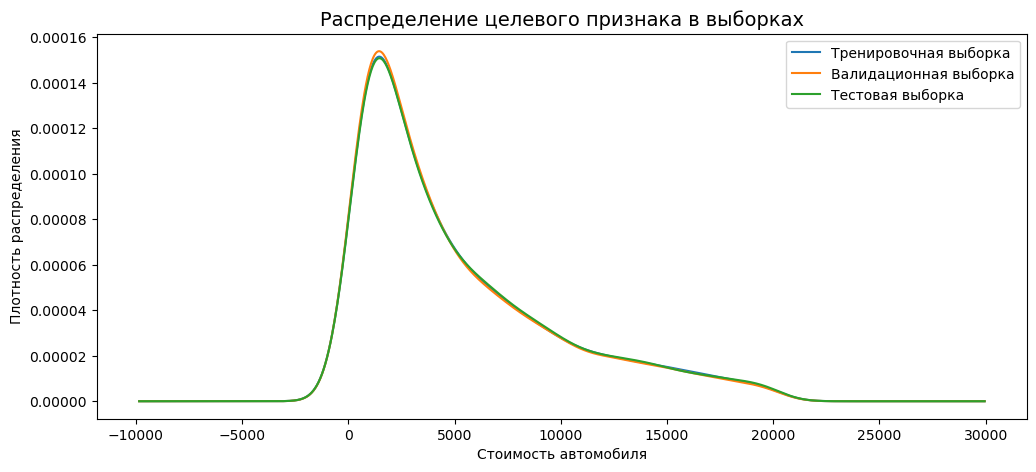

In [32]:
features_train_ho, target_train_ho, features_valid_ho, target_valid_ho, features_test_ho, target_test_ho = \
features_split (features, target, mode='hold_out')

1. Строки порезались корректно - в соотношении 60 : 20 : 20
2. Категориальные признаки распределились неравномерно по столбцу "model". Следует предусмотреть это при обучении энкодеров -- использовать параметры handle_unknown и unknown_value
3. Распределение значений целевого признака совпадает по выборкам

#### 2.1.2 Кодирование категориальных признаков (с валидационной выборкой)

Обучим энкодеры для One-Hot Encoding и Ordinal Encoding:

In [33]:
o_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=300) 
o_encoder.fit(features_train_ho[cat_features])

o_h_encoder = OneHotEncoder(handle_unknown='ignore', drop='first')
o_h_encoder.fit(features_train_ho[cat_features])
display()

Определим функцию **features_prep**, котрая получает на вход выборку с признаками, возвращает выборки с закодированными признаками:

In [34]:
def features_prep (f):
    
# Готовим One-Hot Encoding
    f_ohe = f.join(pd.DataFrame(o_h_encoder.transform(f[cat_features]).toarray(), \
                                                          columns=o_h_encoder.get_feature_names_out()))
    f_ohe = f_ohe.drop(cat_features, axis=1)
    print('OHE shape:', f_ohe.shape, '\n')
    display(f_ohe.head(2))

# Готовим Ordinal Encoding
    f_oe = f.copy()
    f_oe[cat_features] = o_encoder.transform(f_oe[cat_features])
    print('OE shape:', f_oe.shape)
    display(f_oe.head(2))
    
# Готовим Category Data Type
    f_cat = f.copy()
    f_cat[cat_features] = f_cat[cat_features].astype('category')
    print('\nCat info:\n')
    f_cat.info()
    
    return f_ohe, f_oe, f_cat

Закодируем признаки для features_train_ho:

In [35]:
features_train_ho_ohe, features_train_ho_oe, features_train_ho_cat = features_prep(features_train_ho)

OHE shape: (151033, 305) 



,registration_year_month,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_wagon,...,brand_skoda,brand_smart,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_other,repaired_yes
0,200201,143,150000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,201102,235,70000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


OE shape: (151033, 9)


,vehicle_type,registration_year_month,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,2.0,200201,1.0,143,11.0,150000,5.0,2.0,0.0
1,4.0,201102,1.0,235,10.0,70000,5.0,26.0,0.0



Cat info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151033 entries, 0 to 151032
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   vehicle_type             151033 non-null  category
 1   registration_year_month  151033 non-null  int64   
 2   gearbox                  151033 non-null  category
 3   power                    151033 non-null  int64   
 4   model                    151033 non-null  category
 5   kilometer                151033 non-null  int64   
 6   fuel_type                151033 non-null  category
 7   brand                    151033 non-null  category
 8   repaired                 151033 non-null  category
dtypes: category(6), int64(3)
memory usage: 4.5 MB


Закодируем признаки для features_valid_ho:

In [36]:
features_valid_ho_ohe, features_valid_ho_oe, features_valid_ho_cat = features_prep(features_valid_ho)

OHE shape: (50345, 305) 



,registration_year_month,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_wagon,...,brand_skoda,brand_smart,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_other,repaired_yes
0,201009,136,100000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,200707,200,125000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


OE shape: (50345, 9)


,vehicle_type,registration_year_month,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,4.0,201009,0.0,136,43.0,100000,2.0,36.0,0.0
1,2.0,200707,1.0,200,223.0,125000,5.0,1.0,0.0



Cat info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50345 entries, 0 to 50344
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   vehicle_type             50345 non-null  category
 1   registration_year_month  50345 non-null  int64   
 2   gearbox                  50345 non-null  category
 3   power                    50345 non-null  int64   
 4   model                    50345 non-null  category
 5   kilometer                50345 non-null  int64   
 6   fuel_type                50345 non-null  category
 7   brand                    50345 non-null  category
 8   repaired                 50345 non-null  category
dtypes: category(6), int64(3)
memory usage: 1.5 MB


Закодируем признаки для features_test_ho:

In [37]:
features_test_ho_ohe, features_test_ho_oe, features_test_ho_cat = features_prep(features_test_ho)

OHE shape: (50345, 305) 



,registration_year_month,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_wagon,...,brand_skoda,brand_smart,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_other,repaired_yes
0,199901,40,150000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,201201,140,100000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


OE shape: (50345, 9)


,vehicle_type,registration_year_month,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,5.0,199901,1.0,40,199.0,150000,5.0,9.0,0.0
1,4.0,201201,1.0,140,116.0,100000,5.0,38.0,0.0



Cat info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50345 entries, 0 to 50344
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   vehicle_type             50345 non-null  category
 1   registration_year_month  50345 non-null  int64   
 2   gearbox                  50345 non-null  category
 3   power                    50345 non-null  int64   
 4   model                    50345 non-null  category
 5   kilometer                50345 non-null  int64   
 6   fuel_type                50345 non-null  category
 7   brand                    50345 non-null  category
 8   repaired                 50345 non-null  category
dtypes: category(6), int64(3)
memory usage: 1.5 MB


Размеры и значения такие, как и предполагалось.

Теперь можем обучить скейлер.

#### 2.1.3 Масштабирование признаков (с валидационной выборкой)

In [38]:
def features_scale (f_train, f_valid, f_test):
    scaler = StandardScaler()
    scaler.fit(f_train)
    
    return scaler.transform(f_train), scaler.transform(f_valid), scaler.transform(f_test)

In [39]:
features_train_ho_ohe[num_features], features_valid_ho_ohe[num_features], features_test_ho_ohe[num_features] = \
features_scale(features_train_ho_ohe[num_features], features_valid_ho_ohe[num_features], features_test_ho_ohe[num_features])

In [40]:
features_train_ho_oe[num_features], features_valid_ho_oe[num_features], features_test_ho_oe[num_features] = \
features_scale(features_train_ho_oe[num_features], features_valid_ho_oe[num_features], features_test_ho_oe[num_features])

In [41]:
features_train_ho_cat[num_features], features_valid_ho_cat[num_features], features_test_ho_cat[num_features] = \
features_scale(features_train_ho_cat[num_features], features_valid_ho_cat[num_features], features_test_ho_cat[num_features])

In [42]:
features_train_ho_oe.head()

,vehicle_type,registration_year_month,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,2.0,-0.112692,1.0,0.315669,11.0,0.605774,5.0,2.0,0.0
1,4.0,1.132137,1.0,1.739017,10.0,-1.557542,5.0,26.0,0.0
2,5.0,-0.104402,1.0,-0.968440,143.0,-0.070262,5.0,38.0,0.0
3,5.0,0.315607,1.0,-0.102053,101.0,-1.016713,5.0,32.0,0.0
4,0.0,1.139045,1.0,-0.906555,166.0,-1.557542,5.0,25.0,2.0


### 2.2 Подготовка выборок (без валидационной выборки)

#### 2.2.1 Разделение (без валидационной выборки)

Размеры выборок:
(188792, 9)
(188792,)
(62931, 9)
(62931,)

Количество уникальных данных в колонке vehicle_type
8 8 
Количество уникальных данных в колонке gearbox
3 3 
Количество уникальных данных в колонке model
249 246 
Количество уникальных данных в колонке fuel_type
6 6 
Количество уникальных данных в колонке brand
40 40 
Количество уникальных данных в колонке repaired
3 3 


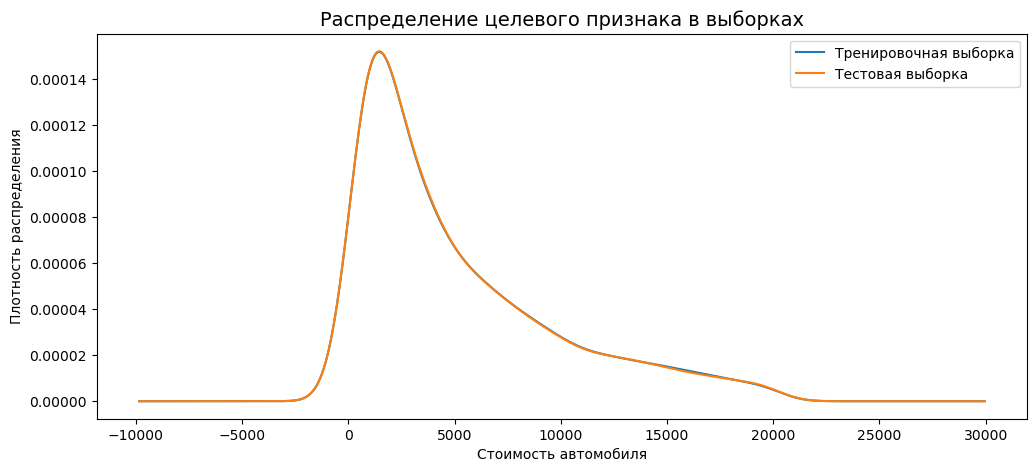

In [43]:
features_train_cv, target_train_cv, features_test_cv, target_test_cv = \
features_split (features, target, mode='cross_validation')

1. Строки порезались корректно - в соотношении 75 : 25
2. Категориальные признаки распределились неравномерно по столбцу "model". Следует предусмотреть это при обучении энкодеров -- использовать параметры handle_unknown и unknown_value
3. Распределение значений целевого признака совпадает по выборкам

#### 2.2.2 Кодирование категориальных признаков (без валидационной выборки)

Обучим энкодеры для One-Hot Encoding и Ordinal Encoding:

In [44]:
o_encoder.fit(features_train_cv[cat_features])

o_h_encoder.fit(features_train_cv[cat_features]);

Закодируем признаки для features_train_cv:

In [45]:
features_train_cv_ohe, features_train_cv_oe, features_train_cv_cat = features_prep(features_train_cv)

OHE shape: (188792, 306) 



,registration_year_month,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_wagon,...,brand_skoda,brand_smart,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_other,repaired_yes
0,200808,52,125000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,200608,163,60000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


OE shape: (188792, 9)


,vehicle_type,registration_year_month,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,5.0,200808,0.0,52,148.0,125000,0.0,3.0,0.0
1,2.0,200608,1.0,163,59.0,60000,5.0,20.0,0.0



Cat info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188792 entries, 0 to 188791
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   vehicle_type             188792 non-null  category
 1   registration_year_month  188792 non-null  int64   
 2   gearbox                  188792 non-null  category
 3   power                    188792 non-null  int64   
 4   model                    188792 non-null  category
 5   kilometer                188792 non-null  int64   
 6   fuel_type                188792 non-null  category
 7   brand                    188792 non-null  category
 8   repaired                 188792 non-null  category
dtypes: category(6), int64(3)
memory usage: 5.6 MB


Закодируем признаки для features_test_cv:

In [46]:
features_test_cv_ohe, features_test_cv_oe, features_test_cv_cat = features_prep(features_test_cv)

OHE shape: (62931, 306) 



,registration_year_month,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_wagon,...,brand_skoda,brand_smart,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_other,repaired_yes
0,199505,150,150000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,200103,60,150000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


OE shape: (62931, 9)


,vehicle_type,registration_year_month,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,7.0,199505,1.0,150,11.0,150000,5.0,2.0,0.0
1,5.0,200103,1.0,60,173.0,150000,5.0,38.0,0.0



Cat info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62931 entries, 0 to 62930
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   vehicle_type             62931 non-null  category
 1   registration_year_month  62931 non-null  int64   
 2   gearbox                  62931 non-null  category
 3   power                    62931 non-null  int64   
 4   model                    62931 non-null  category
 5   kilometer                62931 non-null  int64   
 6   fuel_type                62931 non-null  category
 7   brand                    62931 non-null  category
 8   repaired                 62931 non-null  category
dtypes: category(6), int64(3)
memory usage: 1.9 MB


Размеры и значения такие, как и предполагалось.

Теперь можем обучить скейлер.

#### 2.2.3 Масштабирование признаков (без валидационной выборки)

In [47]:
features_train_cv_ohe[num_features], features_test_cv_ohe[num_features], features_test_cv_ohe[num_features] = \
features_scale(features_train_cv_ohe[num_features], features_test_cv_ohe[num_features], features_test_cv_ohe[num_features])

In [48]:
features_train_cv_oe[num_features], features_test_cv_oe[num_features], features_test_cv_oe[num_features] = \
features_scale(features_train_cv_oe[num_features], features_test_cv_oe[num_features], features_test_cv_oe[num_features])

In [49]:
features_train_cv_cat[num_features], features_test_cv_cat[num_features], features_test_cv_cat[num_features] = \
features_scale(features_train_cv_cat[num_features], features_test_cv_cat[num_features], features_test_cv_cat[num_features])

Все выборки подготовлены для обучения моделей.

## Шаг 3 Обучение моделей 

### 3.1 Обучение с валидационной выборкой

Для начала -- костыль с предзаполнением параметров для проверки работы:

In [50]:
if MODE == 'check':
    
    tree_depth_min, tree_depth_max = 14, 15
    
    cat_iter_min, cat_iter_max = 900, 901
    cat_depth_min, cat_depth_max = 13, 14
    
    lgb_iter_min, lgb_iter_max = 850, 851
    lgb_depth_min, lgb_depth_max = 30, 31
    lgb_leaves_min, lgb_leaves_max = 120, 121
    
    verb = 0
    
else:
    
    tree_depth_min, tree_depth_max = 3, 30
      
    cat_iter_min, cat_iter_max = 100, 901
    cat_depth_min, cat_depth_max = 4, 15
    
    lgb_iter_min, lgb_iter_max = 50, 851
    lgb_depth_min, lgb_depth_max = 30, 121
    lgb_leaves_min, lgb_leaves_max = 20, 321
    
    verb = 10

Подберем гиперпараметры моделей и измерим время на обучение и предсказание:

In [51]:
best_model_for_l_oh = None
best_result_for_l_oh = 5000
best_fit_time_for_l_oh = 0
best_prep_time_for_l_oh = 0

best_model_for_t_oh = None
best_result_for_t_oh = 5000
best_depth_for_t_oh = 0
best_fit_time_for_t_oh = 0
best_prep_time_for_t_oh = 0

best_model_for_c_oh = None
best_result_for_c_oh = 5000
best_iterations_for_c_oh = 0
best_depth_for_c_oh = 0
best_fit_time_for_c_oh = 0
best_prep_time_for_c_oh = 0

best_model_for_gbm_oh = None
best_result_for_gbm_oh = 5000
best_num_iterations_for_gbm_oh = 0
best_max_depth_for_gbm_oh = 0
best_num_leaves_for_gbm_oh = 0
best_fit_time_for_gbm_oh = 0
best_prep_time_for_gbm_oh = 0

# Обучение для LinearRegression
best_model_for_l_oh = LinearRegression() 
start_time = time.time()
best_model_for_l_oh.fit(features_train_ho_ohe, target_train_ho)
end_time = time.time()
best_fit_time_for_l_oh = end_time - start_time
start_time = time.time()
pred = best_model_for_l_oh.predict(features_valid_ho_ohe)
end_time = time.time()
best_prep_time_for_l_oh = end_time - start_time
best_result_for_l_oh = np.sqrt(mean_squared_error(target_valid_ho, pred))


# Подбор гиперпараметров и обучение для DecisionTreeRegressor
for depth in range(tree_depth_min, tree_depth_max):
    model = DecisionTreeRegressor(max_depth=depth, random_state=RAND_FIX)
    start_time = time.time()
    model.fit(features_train_ho_oe, target_train_ho)
    end_time = time.time()
    fit_time = end_time - start_time
    start_time = time.time()
    pred = model.predict(features_valid_ho_oe)
    end_time = time.time()
    prep_time = end_time - start_time
    result = np.sqrt(mean_squared_error(target_valid_ho, pred))
    if result < best_result_for_t_oh:
            best_result_for_t_oh = result
            best_depth_for_t_oh = depth
            best_model_for_t_oh = model
            best_fit_time_for_t_oh = fit_time
            best_prep_time_for_t_oh = prep_time

# Подбор гиперпараметров и обучение для CatBoostRegressor
for iterations in range(cat_iter_min, cat_iter_max, 200):
    for depth in range(cat_depth_min, cat_depth_max):
        model = CatBoostRegressor(learning_rate=0.1, iterations=iterations, depth=depth,\
                                  loss_function='RMSE', random_state=RAND_FIX)
        start_time = time.time()
        model.fit(features_train_ho_cat, target_train_ho, cat_features=cat_features, verbose=verb)
        end_time = time.time()
        fit_time = end_time - start_time
        start_time = time.time()
        pred = model.predict(features_valid_ho_cat)
        end_time = time.time()
        prep_time = end_time - start_time
        result = np.sqrt(mean_squared_error(target_valid_ho, pred))
        if result < best_result_for_c_oh:
            best_result_for_c_oh = result
            best_iterations_for_c_oh = iterations
            best_depth_for_c_oh = depth
            best_model_for_c_oh = model
            best_fit_time_for_c_oh = fit_time
            best_prep_time_for_c_oh = prep_time
                
# Подбор гиперпараметров и обучение для LGBMRegressor
for iterations in range(lgb_iter_min, lgb_iter_max, 400):
    for depth in range(lgb_depth_min, lgb_depth_max, 30):
        for leaves in range(lgb_leaves_min, lgb_leaves_max, 50):
            model = LGBMRegressor(learning_rate=0.1, num_iterations=iterations, max_depth=depth, num_leaves=leaves, \
                                 metric='rmse', verbosity=verb, random_state=RAND_FIX)
            start_time = time.time()
            model.fit(features_train_ho_cat, target_train_ho, categorical_feature=cat_features)
            end_time = time.time()
            fit_time = end_time - start_time
            start_time = time.time()
            pred = model.predict(features_valid_ho_cat)
            end_time = time.time()
            prep_time = end_time - start_time
            result = np.sqrt(mean_squared_error(target_valid_ho, pred))
            if result < best_result_for_gbm_oh:
                best_result_for_gbm_oh = result
                best_num_iterations_for_gbm_oh = iterations
                best_max_depth_for_gbm_oh = depth
                best_num_leaves_for_gbm_oh = leaves
                best_model_for_gbm_oh = model
                best_fit_time_for_gbm_oh = fit_time
                best_prep_time_for_gbm_oh = prep_time            

                
# Публикация результатов
d_res = {'depth/max_depth':[np.nan, best_depth_for_t_oh, best_depth_for_c_oh, best_max_depth_for_gbm_oh],\
         'iterations':[np.nan, np.nan, best_iterations_for_c_oh, best_num_iterations_for_gbm_oh],\
         'leaves':[np.nan, np.nan, np.nan, best_num_leaves_for_gbm_oh],\
         'fit_time':[best_fit_time_for_l_oh, best_fit_time_for_t_oh, best_fit_time_for_c_oh, best_fit_time_for_gbm_oh],\
         'pred_time':[best_prep_time_for_l_oh, best_prep_time_for_t_oh, best_prep_time_for_c_oh, best_prep_time_for_gbm_oh],\
         'RMSE score':[best_result_for_l_oh, best_result_for_t_oh, best_result_for_c_oh, best_result_for_gbm_oh]}
df_res = pd.DataFrame(index=['LinearRegression', 'DecisionTree', 'CatBoost', 'LightGBM'], data=d_res) 

display(df_res)

,depth/max_depth,iterations,leaves,fit_time,pred_time,RMSE score
LinearRegression,NaN,NaN,NaN,1.445089,0.043000,2745.270673
DecisionTree,14.0,NaN,NaN,0.324617,0.009000,1922.172709
CatBoost,13.0,900.0,NaN,432.650452,0.168922,1552.867939
LightGBM,30.0,850.0,120.0,2.819193,0.513475,1541.832191


Лучшими моделями в рамках этого исследования оказались **CatBoost с RMSE == 1552** и **LightGBM с RMSE == 1541**.  
Однако **LightGBM** заметно быстрее учится. На мой взгляд, следует отдать ей предпочтение.

### 3.2 Обучение с кросс-валидацией

Определим скорер:

In [52]:
def rmse_calc(true, pred):
    return np.sqrt(mean_squared_error(true, pred))

In [53]:
rmse_scoring = make_scorer(rmse_calc, greater_is_better=False)

Еще один костыль для проверки работы:

In [54]:
if MODE == 'check':
    
    tree_depth_min, tree_depth_max = 13, 14
    tree_iter = 1
    
    cat_iter_min, cat_iter_max = 900, 901
    cat_depth_min, cat_depth_max = 12, 13
    cat_iter = 1
    
    lgb_iter_min, lgb_iter_max = 450, 451
    lgb_depth_min, lgb_depth_max = 90, 91
    lgb_leaves_min, lgb_leaves_max = 220, 221
    lgb_iter = 1
    
    verb = 0
    
else:
    
    tree_depth_min, tree_depth_max = 3, 30
    tree_iter = 10
    
    cat_iter_min, cat_iter_max = 100, 901
    cat_depth_min, cat_depth_max = 4, 15
    cat_iter = 30
    
    lgb_iter_min, lgb_iter_max = 50, 851
    lgb_depth_min, lgb_depth_max = 30, 121
    lgb_leaves_min, lgb_leaves_max = 20, 321
    lgb_iter = 30
    
    verb = 10

Подберем гиперпараметры моделей и измерим время на обучение:

In [55]:
# Задаем параметры
param_for_l = {}
param_for_t = {'max_depth' : range(tree_depth_min, tree_depth_max)}
param_for_cat = {'learning_rate' : [0.1], \
                 'iterations' : range(cat_iter_min, cat_iter_max, 200), \
                 'depth' : range(cat_depth_min, cat_depth_max), \
                 'loss_function' : ['RMSE']}
param_for_gbm = {'num_iterations' : range(lgb_iter_min, lgb_iter_max, 400), \
                 'max_depth' : range(lgb_depth_min, lgb_depth_max, 30), \
                 'num_leaves' : range(lgb_leaves_min, lgb_leaves_max, 50), \
                 'metric' : ['rmse'], 'verbosity' : [verb]}

# Подбираем и обучаем модели
grid_model_l = RandomizedSearchCV(LinearRegression(), param_distributions = param_for_l, \
                                    n_iter=1, cv=5, scoring=rmse_scoring, random_state=RAND_FIX, verbose=verb)
grid_model_t = RandomizedSearchCV(DecisionTreeRegressor(), param_distributions = param_for_t, \
                                    n_iter=tree_iter, cv=5, scoring=rmse_scoring, random_state=RAND_FIX, verbose=verb)
grid_model_cat = RandomizedSearchCV(CatBoostRegressor(), param_distributions = param_for_cat, \
                                    n_iter=cat_iter, cv=5,  scoring=rmse_scoring, random_state=RAND_FIX, verbose=verb)
grid_model_gbm = RandomizedSearchCV(LGBMRegressor(), param_distributions = param_for_gbm, \
                                    n_iter=lgb_iter, cv=5, scoring=rmse_scoring, random_state=RAND_FIX, verbose=verb)

grid_model_l.fit(features_train_cv_ohe, target_train_cv)
grid_model_t.fit(features_train_cv_oe, target_train_cv)
grid_model_cat.fit(features_train_cv_cat, target_train_cv, cat_features=cat_features, verbose=verb)
grid_model_gbm.fit(features_train_cv_cat, target_train_cv, categorical_feature=cat_features)

# Публикуем результаты
d_res = {'depth/max_depth':[np.nan, grid_model_t.best_params_['max_depth'], \
                            grid_model_cat.best_params_['depth'], grid_model_gbm.best_params_['max_depth']],\
         'iterations':[np.nan, np.nan, \
                       grid_model_cat.best_params_['iterations'], grid_model_gbm.best_params_['num_iterations']],\
         'leaves':[np.nan, np.nan, np.nan, grid_model_gbm.best_params_['num_leaves']],\
         'fit_time':[grid_model_l.refit_time_, grid_model_t.refit_time_, \
                     grid_model_cat.refit_time_, grid_model_gbm.refit_time_],\
         'RMSE score':[abs(grid_model_l.best_score_), abs(grid_model_t.best_score_), \
                       abs(grid_model_cat.best_score_), abs(grid_model_gbm.best_score_)]}
df_res = pd.DataFrame(index=['LinearRegression', 'DecisionTree', 'CatBoost', 'LightGBM'], data=d_res) 

display(df_res)

,depth/max_depth,iterations,leaves,fit_time,RMSE score
LinearRegression,NaN,NaN,NaN,1.884435,2838.412011
DecisionTree,13.0,NaN,NaN,0.389287,1919.749172
CatBoost,12.0,900.0,NaN,326.826630,1547.231806
LightGBM,90.0,450.0,220.0,2.790910,1530.241090


Лучшими моделями в рамках этого исследования оказались CatBoost с **RMSE == 1547** и **LightGBM с RMSE == 1530**.  
Однако **LightGBM** в сто двадцать раз быстрее учится. На мой взгляд, следует отдать ей предпочтение.

Но, так или, иначе проведем отдельный анализ, где сравним скорость предсказаний по всем моделям с лучшими параметрами на тестовой выборке.

Скорость обучения и RMSE score у нас уже есть.

## Шаг 4 Анализ моделей

Я не стал тут использовать %time, так как не нашел, как сохранять выводимые данные в переменную.
Поэтому в этом исследовании использую time.time() из time.

In [56]:
def prep_time(model, test_f):
    start_time = time.time()
    model.predict(test_f)
    end_time = time.time()
    
    return end_time - start_time

In [57]:
d_res = {'fit_time_oh':[best_fit_time_for_l_oh, best_fit_time_for_t_oh, \
                        best_fit_time_for_c_oh, best_fit_time_for_gbm_oh], \
         'pred_time_oh':[prep_time(best_model_for_l_oh, features_test_ho_ohe), \
                     prep_time(best_model_for_t_oh, features_test_ho_oe), \
                     prep_time(best_model_for_c_oh, features_test_ho_cat), \
                     prep_time(best_model_for_gbm_oh, features_test_ho_cat)],
         'RMSE score_oh':[best_result_for_l_oh, best_result_for_t_oh, \
                          best_result_for_c_oh, best_result_for_gbm_oh], \
         ' ****** ':[' ****** ', ' ****** ', ' ****** ', ' ****** '], \
         'fit_time_cv':[grid_model_l.refit_time_, grid_model_t.refit_time_, \
                     grid_model_cat.refit_time_, grid_model_gbm.refit_time_], \
         'pred_time_cv':[prep_time(grid_model_l, features_test_cv_ohe), \
                     prep_time(grid_model_t, features_test_cv_oe), \
                     prep_time(grid_model_cat, features_test_cv_cat), \
                     prep_time(grid_model_gbm, features_test_cv_cat)],
         'RMSE score_cv':[abs(grid_model_l.best_score_), abs(grid_model_t.best_score_), \
                       abs(grid_model_cat.best_score_), abs(grid_model_gbm.best_score_)]}
df_res = pd.DataFrame(index=['LinearRegression', 'DecisionTree', 'CatBoost', 'LightGBM'], data=d_res) 

display(df_res.round(2))

,fit_time_oh,pred_time_oh,RMSE score_oh,******,fit_time_cv,pred_time_cv,RMSE score_cv
LinearRegression,1.45,0.05,2745.27,******,1.88,0.07,2838.41
DecisionTree,0.32,0.01,1922.17,******,0.39,0.01,1919.75
CatBoost,432.65,0.16,1552.87,******,326.83,0.16,1547.23
LightGBM,2.82,0.59,1541.83,******,2.79,0.54,1530.24


Выводы не изменились с предыдущего пункта. Да, у CatBoost примерно в три раза меньше время предсказания, но на два порядка медленнее обучение и хоть и ненамного, но хуже значение RMSE. Опять же, все значения времени прдсказания не превышают половины секунды.

1. Для варианта с фиксированной валидационной выборкой лучшей является модель **LightGBMregressor** с параметрами:
    * num_iterations = 850
    * max_depth = 30
    * num_leaves = 120
    
2. Для варианта с кросс-валидацией лучшей является модель **LightGBMregressor** с параметрами:
    * num_iterations = 450
    * max_depth = 90
    * num_leaves = 220
    
Поэтому тестирование модели будем проводить на выбранных моделях.

## Шаг 5 Тестирование моделей и проверка их на адекватность

Посчитаем для выбранных моделей метрики $RMSE$ и $R^2$ на соответствующих тестовых выборках.

In [58]:
def final_test(model, test_f, test_t):
    pred = model.predict(test_f)
    return np.sqrt(mean_squared_error(test_t, pred)), r2_score(test_t, pred)

In [59]:
d_res = {'RMSE score':[final_test(best_model_for_gbm_oh, features_test_ho_cat, target_test_ho)[0], \
                        final_test(grid_model_gbm, features_test_cv_cat, target_test_cv)[0]], \
         'R^2 score':[final_test(best_model_for_gbm_oh, features_test_ho_cat, target_test_ho)[1], \
                     final_test(grid_model_gbm, features_test_cv_cat, target_test_cv)[1]]}

df_res = pd.DataFrame(index=['Фиксированная валид. выборка', 'Кросс-валидация'], data=d_res) 

display(df_res.round(2))

,RMSE score,R^2 score
Фиксированная валид. выборка,1541.00,0.89
Кросс-валидация,1544.96,0.89


### 5.1 Сравнение с константной моделью

Для наглядности расчитаем RMSE на константной моедели и сравним с нашими результатами:

In [60]:
dummy_model_ho = DummyRegressor() #Инициация(ho)
dummy_model_ho.fit(features_train_ho_cat, target_train_ho) # Обучение на тренировочной выборке (ho)
dummy_model_ho_pred = dummy_model_ho.predict(features_test_ho_cat) 
dummy_model_ho_rmse = np.sqrt(mean_squared_error(target_test_ho, dummy_model_ho_pred))

dummy_model_cv = DummyRegressor() #Инициация(cv)
dummy_model_cv.fit(features_train_cv_cat, target_train_cv) # Обучение на тренировочной выборке (cv)
dummy_model_cv_pred = dummy_model_cv.predict(features_test_cv_cat)
dummy_model_cv_rmse = np.sqrt(mean_squared_error(target_test_cv, dummy_model_cv_pred))

print('RMSE score на тесте для варианта с фиксированной валидационной выборки для константной модели: {:.2f}'\
      .format(dummy_model_ho_rmse))
print('RMSE score на тесте для варианта с применением кросс-валидации для константной модели: {:.2f}'\
      .format(dummy_model_cv_rmse))

RMSE score на тесте для варианта с фиксированной валидационной выборки для константной модели: 4685.77
RMSE score на тесте для варианта с применением кросс-валидации для константной модели: 4661.36


## Общий вывод

В ходе исследования построена модель, которая с достаточной точностью предсказывала бы для клиентов стоимость автомобиля по предложенным параметрам.

Дополнительно были учтены:
* качество предсказания
* скорость предсказания
* время обучения

Таким образом, исследование состояло из следующих этапов, на каждом из которых формировались выводы, которые попали в итоги работы:  
1. Загрузка, обзор и предобработка данных
2. Подготовка выборок под различные модели
3. Обучение моделей и подбор гиперпараметров
4. Выбор модели исходя из значения RMSE и скорости обучения и предсказания
5. Тестирование выбранной модели и проверка ее на адекватность

### Результаты исследования

Для прогнозирования стоимости автомобиля предлагаю использовать модель:

1. Вариант с фиксированной валидационной выборкой
    * **LightGBM** regressor с параметрами:
        * num_iterations = 850
        * max_depth = 30
        * num_leaves = 120    
    * Результаты работы модели на тестовой выборке:
        * $RMSE$ = 1 541.00
        * $R^2$ = 0.9
2. Вариант с кросс-валидацией
    * **LightGBM** regressor с параметрами:
        * num_iterations = 450
        * max_depth = 90
        * num_leaves = 220    
    * Результаты работы модели на тестовой выборке:
        * $RMSE$ = 1 544.96	
        * $R^2$ = 0.9